## Посмотрим датасет (какие столбцы есть и какие пропуски. Примем решение, что делать с пропусками)

In [59]:
import pandas as pd
from scipy.stats import f_oneway, ttest_ind, kruskal, levene, mannwhitneyu, shapiro, chi2_contingency
import seaborn as sns
import matplotlib.pyplot as plt


data = pd.read_csv('data_graduates_university_specialty_124_v20240709.csv', sep=';')

print("Общая информация о данных")
print(data.info())

Общая информация о данных
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 599971 entries, 0 to 599970
Data columns (total 14 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   object_level       599971 non-null  object 
 1   object_name        599971 non-null  object 
 2   gender             599971 non-null  object 
 3   education_level    599971 non-null  object 
 4   year               599971 non-null  int64  
 5   university         599971 non-null  object 
 6   specialty_section  599971 non-null  object 
 7   specialty          599971 non-null  object 
 8   specialty_code     599971 non-null  object 
 9   count_graduate     599971 non-null  int64  
 10  percent_employed   599971 non-null  float64
 11  average_salary     261227 non-null  float64
 12  oktmo              599971 non-null  int64  
 13  okato              599971 non-null  int64  
dtypes: float64(2), int64(4), object(8)
memory usage: 64.1+ MB
None


In [60]:
missing_values = data.isnull().sum()
print("\nКоличество пропусков по столбцам:")
print(missing_values)


Количество пропусков по столбцам:
object_level              0
object_name               0
gender                    0
education_level           0
year                      0
university                0
specialty_section         0
specialty                 0
specialty_code            0
count_graduate            0
percent_employed          0
average_salary       338744
oktmo                     0
okato                     0
dtype: int64


### Видим много пропусков в average_salary (больше половины значений). Не будем учитывать их при анализе, так что удалим эти строки с пропусками.

In [61]:
data = data.dropna(subset=['average_salary'])
missing_values = data.isnull().sum()
print("\nКоличество пропусков по столбцам:")
print(missing_values)


Количество пропусков по столбцам:
object_level         0
object_name          0
gender               0
education_level      0
year                 0
university           0
specialty_section    0
specialty            0
specialty_code       0
count_graduate       0
percent_employed     0
average_salary       0
oktmo                0
okato                0
dtype: int64


# Гипотеза 1. Средняя зарплата зависит от уровня образования

In [62]:
# Посмотрим на уникальные уровни образования
education_levels = data['education_level'].unique()
print("Уровни образования:", education_levels)

Уровни образования: ['СПО: квалифицированные рабочие и служащие'
 'СПО: специалисты среднего звена' 'Бакалавриат, специалитет'
 'Магистратура']


In [63]:
# Группировка данных по уровню образования
groups = [data[data['education_level'] == level]['average_salary'] for level in education_levels]

In [64]:
from scipy.stats import kruskal, levene, f_oneway

# Проверка условий для ANOVA
levene_test = levene(*groups)

# Если условия равенства дисперсий соблюдаются, используем ANOVA; иначе — Краскела-Уоллиса
if levene_test.pvalue > 0.05:
    result = f_oneway(*groups)
    print("ANOVA p-value:", result.pvalue)
else:
    result = kruskal(*groups)
    print("Краскела-Уоллиса p-value:", result.pvalue)

Краскела-Уоллиса p-value: 0.0


### Вывод: p-value = 0.0 означает, что вероятность случайного возникновения таких различий крайне мала (меньше 0.05). Следовательно, можно с высокой степенью уверенности заявить, что на самом деле средняя зарплата зависит от уровня образования  

# Гипотеза 2. Доля трудоустроенных выпускников зависит от пола

In [65]:
# Разделим данные по полу
male_employed = data[data['gender'] == 'Мужской']['percent_employed']
female_employed = data[data['gender'] == 'Женский']['percent_employed']

Манна-Уитни p-value: 0.0


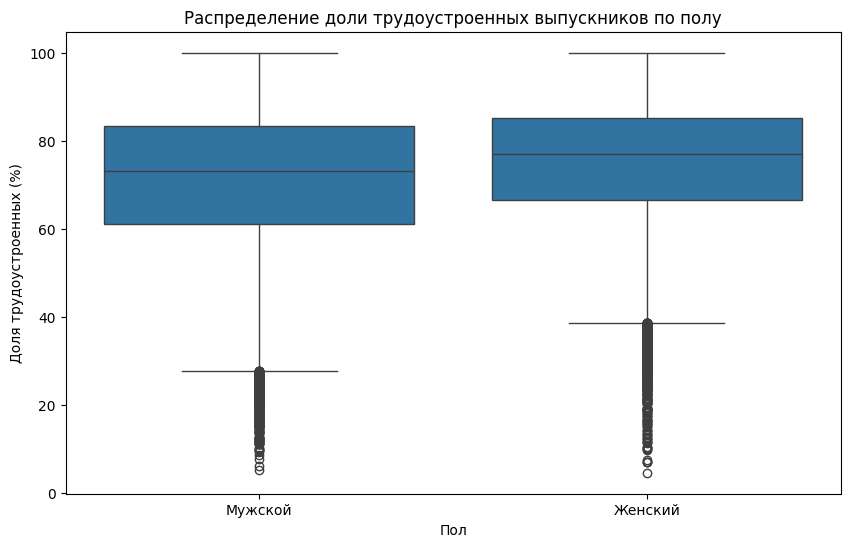

In [66]:
from scipy.stats import ttest_ind, mannwhitneyu, levene

# Разделим данные по полу
male_employed = data[data['gender'] == 'Мужской']['percent_employed']
female_employed = data[data['gender'] == 'Женский']['percent_employed']

# Проверка равенства дисперсий с помощью теста Левена
levene_test = levene(male_employed, female_employed)

# Выбор теста на основе результатов теста Левена
if levene_test.pvalue > 0.05:
    # Если дисперсии равны, используем t-тест для независимых выборок
    result = ttest_ind(male_employed, female_employed)
    print("t-тест p-value:", result.pvalue)
else:
    # В противном случае используем тест Манна-Уитни
    result = mannwhitneyu(male_employed, female_employed)
    print("Манна-Уитни p-value:", result.pvalue)

plt.figure(figsize=(10, 6))
sns.boxplot(data=data[data['gender'].isin(['Мужской', 'Женский'])], x='gender', y='percent_employed')
plt.title('Распределение доли трудоустроенных выпускников по полу')
plt.xlabel('Пол')
plt.ylabel('Доля трудоустроенных (%)')
plt.show()

## Вывод: p-value = 0.0 говорит о том, что вероятность случайного возникновения таких различий крайне мала (меньше 0.05). Это позволяет  утверждать, что доля трудоустроенных выпускников зависит от пола.
## Также можем видеть на диаграмме наличие выбросов (в женской группе), что может свидетельствовать о меньшей трудоустроенности в некоторых случаях.

# Гипотеза 3.  Доля трудоустроенных выпускников различается в зависимости от уровня образования (СПО, бакалавриат, магистратура и т.д.).

In [67]:
# Проверяем доступные уровни образования
print(data['education_level'].unique())

# Группируем данные по уровню образования и рассчитываем среднюю долю трудоустроенных
grouped_data = data.groupby('education_level')['percent_employed'].mean().reset_index()
print(grouped_data)

['СПО: квалифицированные рабочие и служащие'
 'СПО: специалисты среднего звена' 'Бакалавриат, специалитет'
 'Магистратура']
                             education_level  percent_employed
0                   Бакалавриат, специалитет         75.837882
1                               Магистратура         83.001123
2  СПО: квалифицированные рабочие и служащие         69.262983
3            СПО: специалисты среднего звена         65.930139


In [68]:
from scipy.stats import normaltest

# Проверяем нормальность распределения доли трудоустроенных для каждой группы
for level in data['education_level'].unique():
    level_data = data[data['education_level'] == level]['percent_employed']
    stat, p = normaltest(level_data)
    print(f"Уровень образования: {level}, p-value (D'Агостино-К^2): {p}")

Уровень образования: СПО: квалифицированные рабочие и служащие, p-value (D'Агостино-К^2): 0.0
Уровень образования: СПО: специалисты среднего звена, p-value (D'Агостино-К^2): 3.428614015210414e-88
Уровень образования: Бакалавриат, специалитет, p-value (D'Агостино-К^2): 0.0
Уровень образования: Магистратура, p-value (D'Агостино-К^2): 0.0


In [69]:
# Группируем данные для теста Краскела-Уоллиса
groups = [data[data['education_level'] == level]['percent_employed'] for level in data['education_level'].unique()]

# Применяем тест
stat, p = kruskal(*groups)
print(f"Краскела-Уоллис p-value: {p}")

# Вывод
if p < 0.05:
    print("Между уровнями образования есть статистически значимые различия в долях трудоустроенных.")
else:
    print("Статистически значимых различий между уровнями образования не обнаружено.")

Краскела-Уоллис p-value: 0.0
Между уровнями образования есть статистически значимые различия в долях трудоустроенных.


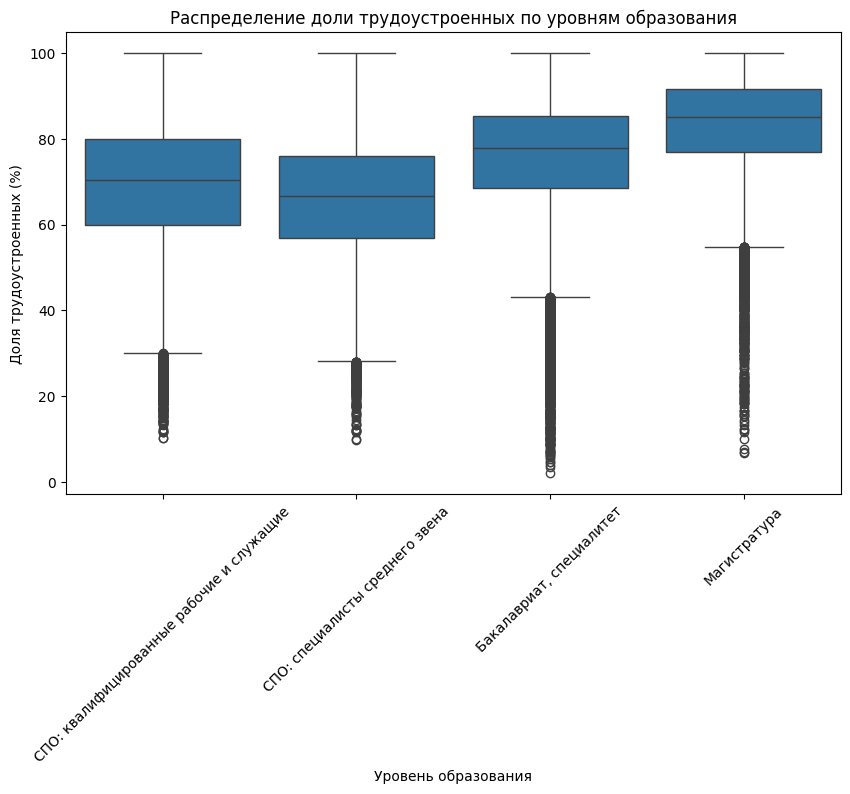

In [70]:
# Построим ящичковую диаграмму
plt.figure(figsize=(10, 6))
sns.boxplot(data=data, x='education_level', y='percent_employed')
plt.title('Распределение доли трудоустроенных по уровням образования')
plt.xlabel('Уровень образования')
plt.ylabel('Доля трудоустроенных (%)')
plt.xticks(rotation=45)
plt.show()

## Выводы: 
1) По Краскелу-Уоллису можем увидеть, что всё же существует статистическая значимость между уровнями образования (p-value < 0.05).
2) Выпускники с уровнем образования - магистратура - показывают больший процент трудоустройства по сравнению с другими уровнями.
3) Уровни СПО демонстрируют меньшую долю трудоустроенных, особенно у специалистов среднего звена (~55%).

# Гипотеза 4. Разница зарплаты выпускников по регионам (Москва, Санкт-Петербург, Казань, Владивосток)

Краскела-Уоллиса p-value: 2.0271760727672614e-123


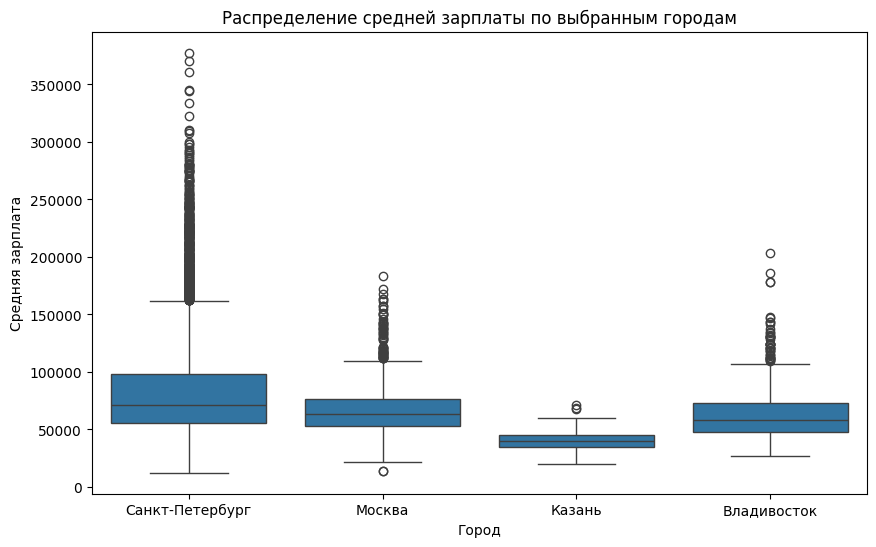

In [71]:
# Фильтрация по городам на основе ключевых слов в названии университета
city_keywords = {
    'Москва': 'Москва', 
    'Санкт-Петербург': 'Санкт-Петербург', 
    'Казань': 'Казань', 
    'Владивосток': 'Владивосток'
}

# Создаем новый столбец для города на основе ключевых слов в названии университета
data['city'] = data['university'].apply(lambda x: next((city for city, keyword in city_keywords.items() if keyword in x), None))

# Фильтруем данные, оставляя только нужные города
cities_of_interest = ['Москва', 'Санкт-Петербург', 'Казань', 'Владивосток']
filtered_data = data[data['city'].isin(cities_of_interest)]

# Удаляем строки с пропусками в столбце average_salary
filtered_data = filtered_data.dropna(subset=['average_salary'])

# Фильтруем только города с количеством значений `average_salary` >= 10
filtered_data = filtered_data.groupby('city').filter(lambda x: x['average_salary'].count() >= 10)

# Группировка данных по городам для теста Крускала-Уоллиса
groups = [filtered_data[filtered_data['city'] == city]['average_salary'] for city in cities_of_interest]

# Применяем тест Крускала-Уоллиса для проверки различий
result = kruskal(*groups)
print("Краскела-Уоллиса p-value:", result.pvalue)

# Визуализация: ящичковая диаграмма средней зарплаты по выбранным городам
plt.figure(figsize=(10, 6))
sns.boxplot(data=filtered_data, x='city', y='average_salary')
plt.title('Распределение средней зарплаты по выбранным городам')
plt.xlabel('Город')
plt.ylabel('Средняя зарплата')
plt.show()

## Выводы: 

    1)Краскела-Уоллиса p-value значительно меньше 0.05. Это указывает на статистически значимую разницу в средней зарплате выпускников между выбранными городами (Москва, Санкт-Петербург, Казань и Владивосток).   
    2) Выпускники Казанских учебных заведений получают меньшие зарплаты по сравнению с Московой, Санкт-Петербургом и Владивостоком.
    3) Санкт-Петербург имеет более высокую медианную зарплату по сравнению с другими городами, а также показывает большую вариативность зарплат, включая множество выбросов (высокие зарплаты).
    4) Зарплаты выпускников учебных заведений Москвы и Владивостока схожи.

# Гипотеза 5. Доля трудоустроенных выпускников различается между сферами подготовки (например, ИТ, медицина, сельское хозяйство и т.д.).

Количество записей после объединения: 233123
Сферы подготовки: sphere
Инженерия                 55964
Экономика и управление    45305
Строительство             22125
ИТ                        21504
Образование               19048
Право                     17049
Медицина                  13678
Сельское хозяйство        13162
Гуманитарные науки        10380
Искусство и творчество     5820
Спорт                      3941
Наука                      3495
Прочее                     1652
Name: count, dtype: int64


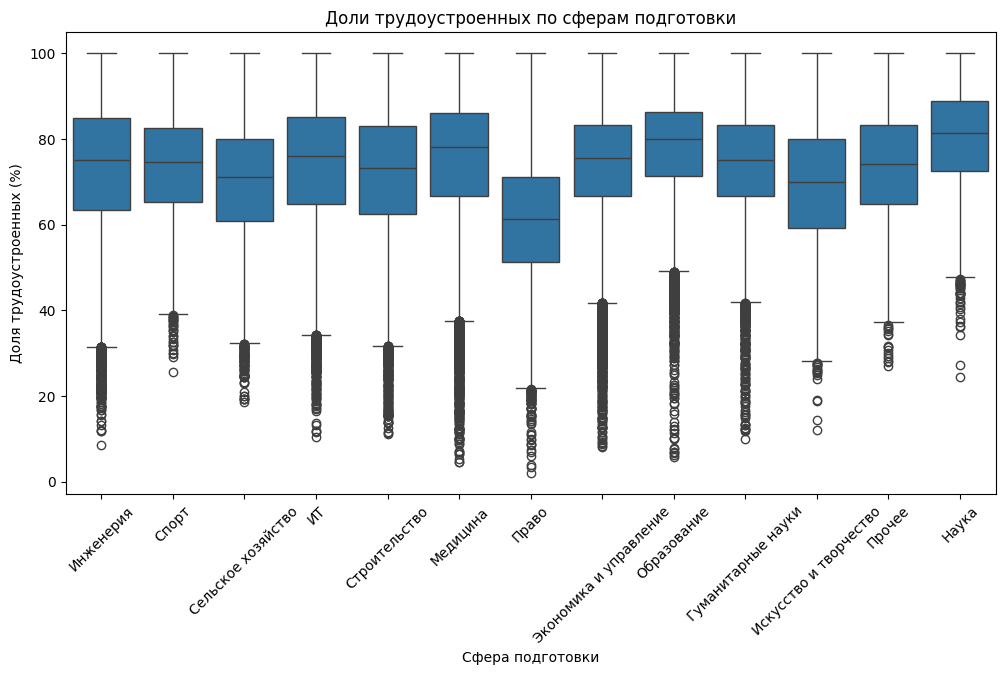


Анализ с использованием теста Краскела-Уоллиса
Краскела-Уоллис: p-value = 0.0
Есть статистически значимые различия между сферами.

Анализ с использованием Хи-квадрат
Хи-квадрат: p-value = 0.0
Есть статистически значимая зависимость между сферой подготовки и уровнем трудоустроенности.


In [72]:
# Определяем словарь сфер
sphere_dict = {
    'ИТ': [
        'Информатика и вычислительная техника', 'Информационная безопасность', 
        'Компьютерные и информационные науки', 'Управление в технических системах'
    ],
    'Медицина': [
        'Клиническая медицина', 'Сестринское дело', 'Фармация', 
        'Науки о здоровье и профилактическая медицина', 'Фундаментальная медицина'
    ],
    'Сельское хозяйство': [
        'Сельское, лесное и рыбное хозяйство', 'Ветеринария и зоотехния', 
        'Прикладная геология, горное дело, нефтегазовое дело'
    ],
    'Инженерия': [
        'Авиационная и ракетно-космическая техника', 'Машиностроение', 
        'Техника и технологии кораблестроения и водного транспорта', 
        'Техника и технологии наземного транспорта', 'Технологии материалов',
        'Электро- и теплоэнергетика', 'Электроника, радиотехника и системы связи'
    ],
    'Наука': [
        'Математика и механика', 'Физика и астрономия', 'Химия', 
        'Физико-технические науки и технологии', 'Нанотехнологии и наноматериалы'
    ],
    'Экономика и управление': [
        'Экономика и управление', 'Политические науки и регионоведение', 
        'Социология и социальная работа'
    ],
    'Гуманитарные науки': [
        'Философия, этика и религиоведение', 'История и археология', 
        'Культуроведение и социокультурные проекты', 'Языкознание и литературоведение', 
        'Психологические науки'
    ],
    'Искусство и творчество': [
        'Музыкальное искусство', 'Изобразительное и прикладные виды искусств', 
        'Сценические искусства и литературное творчество', 'Экранные искусства', 
        'Искусствознание'
    ],
    'Право': ['Юриспруденция'],
    'Образование': [
        'Образование и педагогические науки', 'Средства массовой информации и информационно-библиотечное дело'
    ],
    'Строительство': [
        'Техника и технологии строительства', 'Техносферная безопасность и природообустройство', 
        'Промышленная экология и биотехнологии'
    ],
    'Спорт': ['Физическая культура и спорт'],
    'Прочее': [
        'Обеспечение государственной безопасности', 'Архитектура', 
        'Теология', 'Оружие и системы вооружения'
    ]
}

# Преобразуем словарь сфер в DataFrame для быстрого поиска
sphere_mapping = []
for sphere, specialties in sphere_dict.items():
    for specialty in specialties:
        sphere_mapping.append({'specialty_section': specialty.strip().lower(), 'sphere': sphere})

# Создаем DataFrame из словаря
sphere_df = pd.DataFrame(sphere_mapping)

# Приводим specialty_section в обоих DataFrame к нижнему регистру
data['specialty_section'] = data['specialty_section'].str.strip().str.lower()
sphere_df['specialty_section'] = sphere_df['specialty_section'].str.strip().str.lower()

# Объединяем данные
merged_data = data.merge(sphere_df, on='specialty_section', how='inner')

# Проверяем результат объединения
print(f"Количество записей после объединения: {len(merged_data)}")
print(f"Сферы подготовки: {merged_data['sphere'].value_counts()}")

# Визуализация долей трудоустроенных по сферам
plt.figure(figsize=(12, 6))
sns.boxplot(data=merged_data, x='sphere', y='percent_employed')
plt.title('Доли трудоустроенных по сферам подготовки')
plt.xticks(rotation=45)
plt.xlabel('Сфера подготовки')
plt.ylabel('Доля трудоустроенных (%)')
plt.show()

# Анализ долей трудоустроенных с помощью теста Краскела-Уоллиса
print("\nАнализ с использованием теста Краскела-Уоллиса")
groups = [merged_data[merged_data['sphere'] == sphere]['percent_employed'] for sphere in merged_data['sphere'].unique()]
stat, p_kruskal = kruskal(*groups)
print(f"Краскела-Уоллис: p-value = {p_kruskal}")

if p_kruskal < 0.05:
    print("Есть статистически значимые различия между сферами.")
else:
    print("Статистически значимых различий между сферами не обнаружено.")

# Анализ зависимости категорий с использованием Хи-квадрат
print("\nАнализ с использованием Хи-квадрат")
# Преобразование в категориальные уровни (например, высокая и низкая трудоустроенность)
merged_data['employment_category'] = pd.cut(
    merged_data['percent_employed'], bins=[0, 50, 100], labels=['Низкая', 'Высокая']
)

contingency_table = pd.crosstab(merged_data['sphere'], merged_data['employment_category'])
stat, p_chi2, dof, expected = chi2_contingency(contingency_table)

print(f"Хи-квадрат: p-value = {p_chi2}")
if p_chi2 < 0.05:
    print("Есть статистически значимая зависимость между сферой подготовки и уровнем трудоустроенности.")
else:
    print("Зависимость между сферой подготовки и уровнем трудоустроенности не обнаружена.")

## Выводы: 
	1.	Сферы с наибольшей трудоустроенностью: Сферы “ИТ”, “Инженерия” и “Медицина” демонстрируют высокий уровень трудоустроенности выпускников, что указывает на их востребованность на рынке труда.
	2.	Проблемы в некоторых направлениях: Выпускники сфер “Искусство и творчество” и “Гуманитарные науки” имеют низкую долю трудоустроенности, что может свидетельствовать о сложностях с трудоустройством или ограниченном рынке вакансий в данных областях.
	3.	Статистическая значимость различий: Анализ показал, что различия в долях трудоустроенных между сферами подготовки являются статистически значимыми (тесты Краскела-Уоллиса и хи-квадрат).
	4.	Рынок труда требует адаптации: Образовательные программы в сферах с низкой трудоустроенностью могут требовать пересмотра или адаптации под потребности рынка.
	5.	Рекомендации для абитуриентов: Результаты подчеркивают важность выбора сферы обучения для будущего трудоустройства. Абитуриентам стоит ориентироваться на востребованные направления, такие как “ИТ” и “Инженерия”.